<div style="background-color: #22A7F0; padding: 10px; text-align: center; font-size: 28px; color: white;">
   <br>
    World Happiness Report 2022
   <br>
    <br>
    
</div>


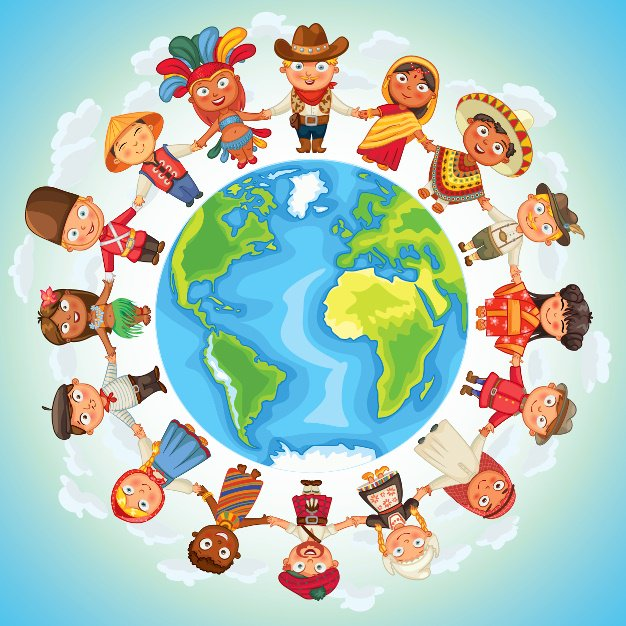

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import geopandas as gpd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

In [2]:
df=pd.read_csv('World Happiness Report 2022.csv')
df.head(7)

,RANK,Country,Happiness score,Whisker-high,Whisker-low,Dystopia (1.83),GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,6,Luxembourg*,7.40,7.50,7.31,2.04,2.21,1.16,0.79,0.70,0.12,0.39
1,27,Singapore,6.48,6.57,6.39,0.93,2.15,1.13,0.85,0.67,0.16,0.59
2,13,Ireland,7.04,7.12,6.96,1.74,2.13,1.17,0.78,0.63,0.19,0.41
3,4,Switzerland,7.51,7.59,7.44,2.15,2.03,1.23,0.82,0.68,0.15,0.46
4,24,United Arab Emirates,6.58,6.66,6.49,1.81,2.00,0.98,0.63,0.70,0.20,0.25
5,8,Norway,7.37,7.44,7.29,1.93,2.00,1.24,0.79,0.73,0.22,0.47
6,16,United States,6.98,7.07,6.89,2.21,1.98,1.18,0.63,0.57,0.22,0.18


In [3]:
df.shape

(146, 12)

In [4]:
df.isna().sum()

RANK                            0
Country                         0
Happiness score                 0
Whisker-high                    0
Whisker-low                     0
Dystopia (1.83)                 0
GDP per capita                  0
 Social support                 0
 Healthy life expectancy        0
Freedom to make life choices    0
 Generosity                     0
 Perceptions of corruption      0
dtype: int64

In [5]:
data=df.iloc[:,2:]
data.drop(['Whisker-high','Whisker-low'],axis=1,inplace=True)

# Have a better look to data

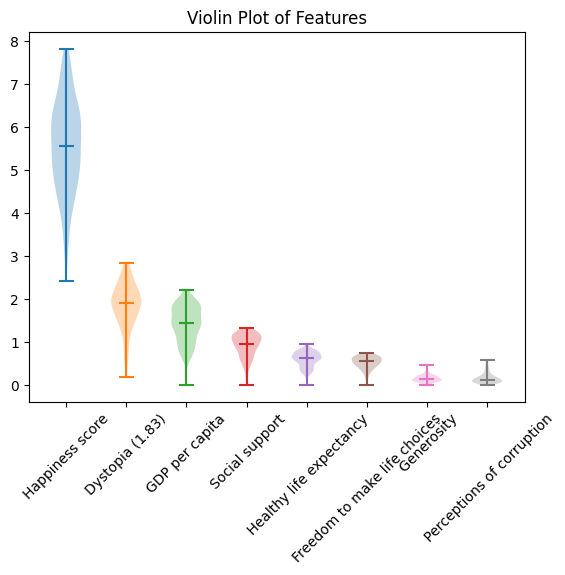

In [6]:
fig, ax = plt.subplots()

for i, feature in enumerate(data.columns):
    ax.violinplot(data[feature], positions=[i], showmedians=True)

ax.set_xticks(np.arange(len(data.columns)))
ax.set_xticklabels(data.columns, rotation=45)

ax.set_title("Violin Plot of Features")
plt.show()

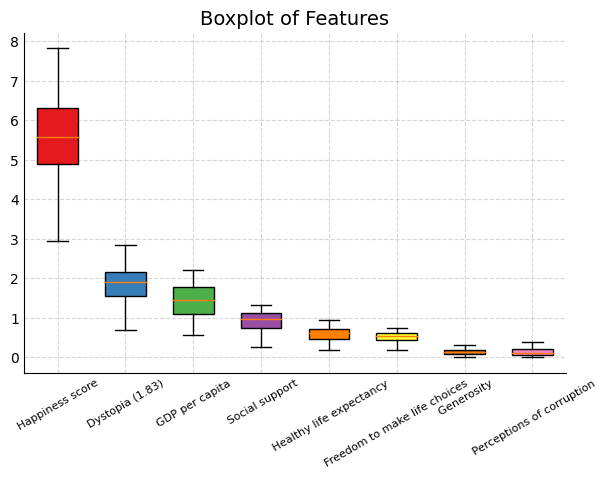

In [7]:
fig, ax = plt.subplots(figsize=(7, 5))
cmap = get_cmap('Set1')
num_colors = len(data.columns)
for i, feature in enumerate(data.columns):
    color_index = i / num_colors
    box_color = cmap(color_index)
    box = ax.boxplot(data[feature], positions=[i], showfliers=False, widths=0.6, patch_artist=True)
    for patch in box['boxes']:
        patch.set_facecolor(box_color)

ax.set_xticks(np.arange(len(data.columns)))
ax.set_xticklabels(data.columns, rotation=30, fontsize=8)
ax.set_title("Boxplot of Features", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
plt.subplots_adjust(bottom=0.2)
plt.show()

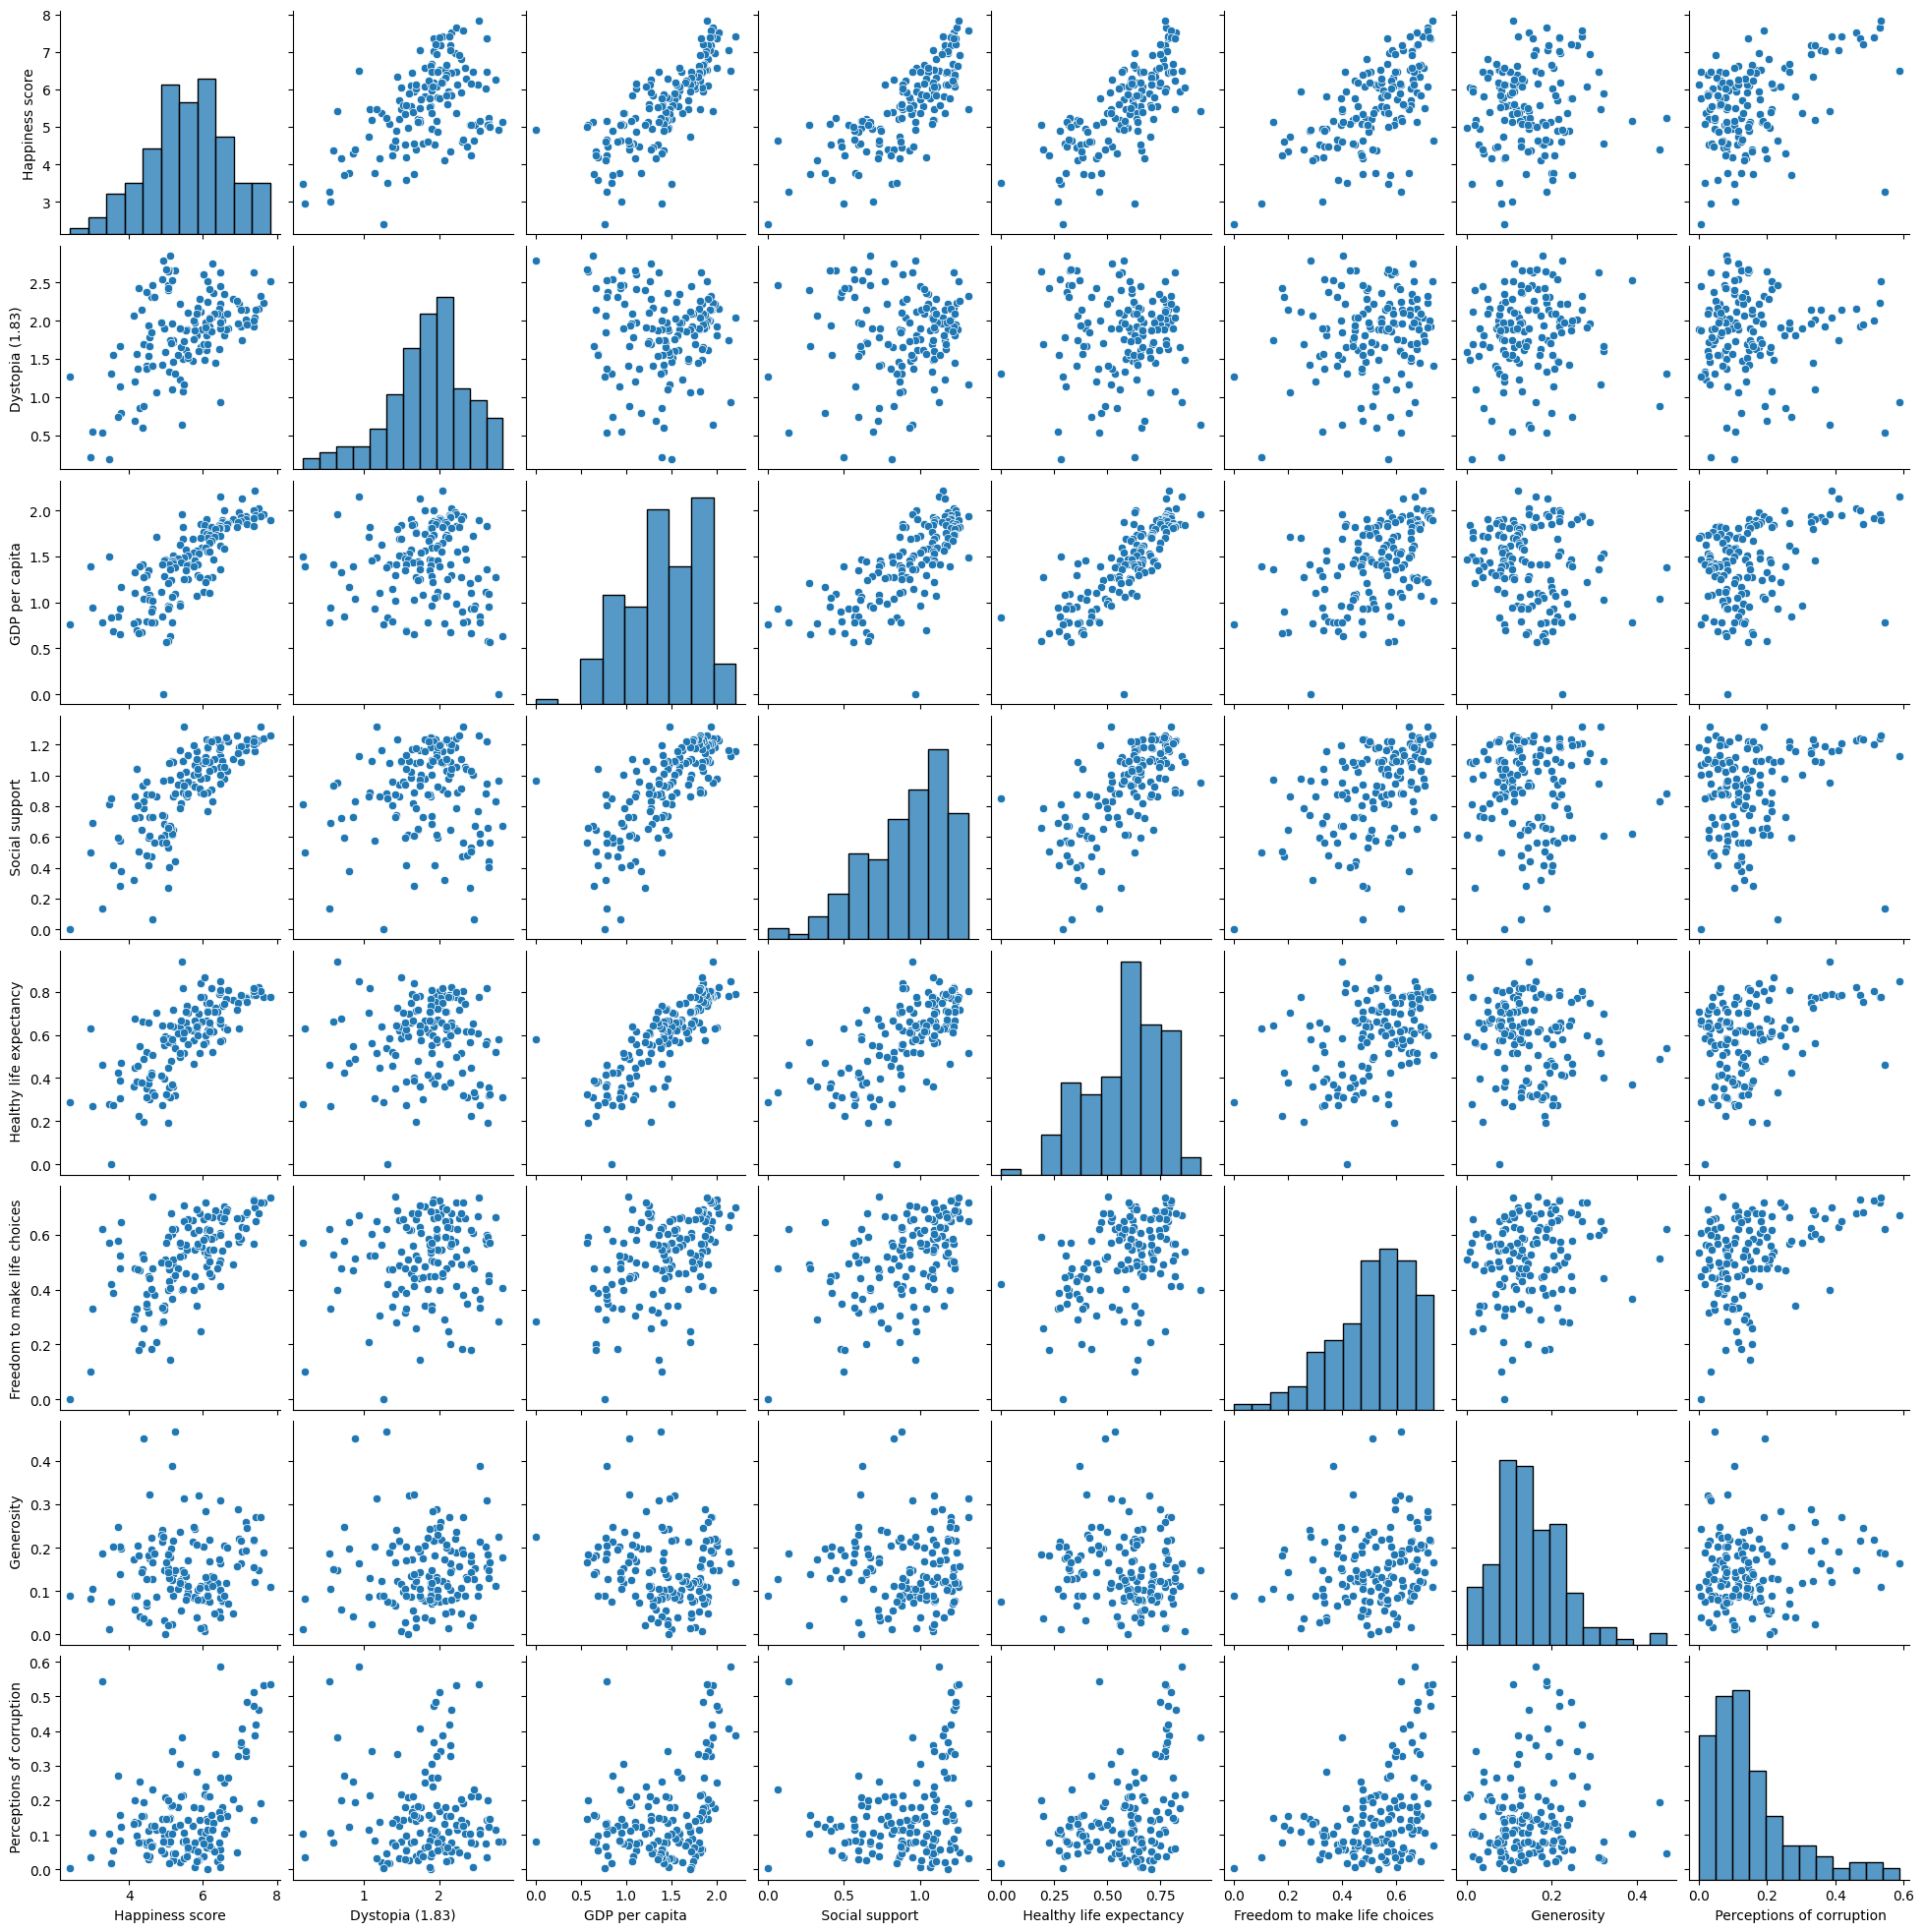

In [8]:
sns.pairplot(data)
plt.show()

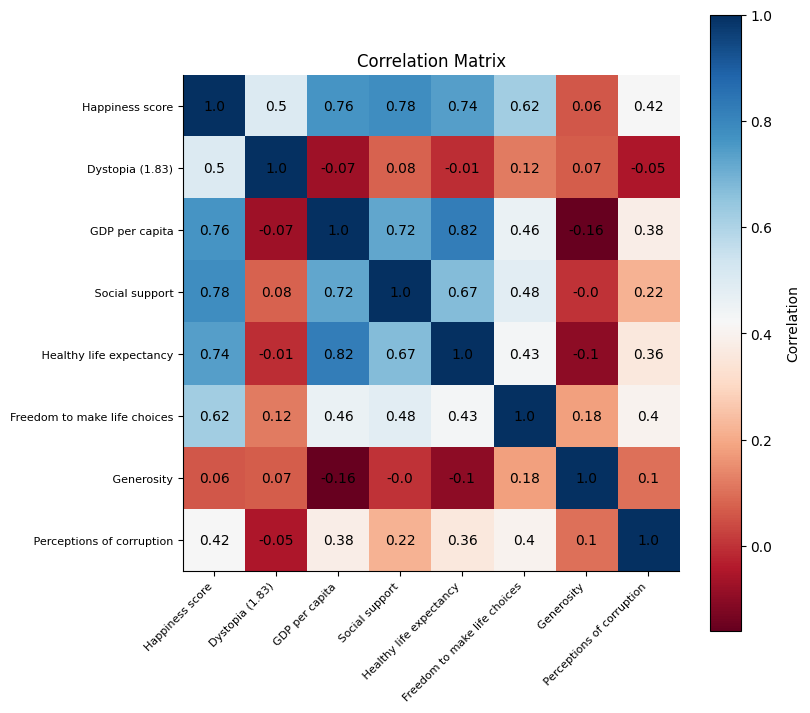

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
corr_matrix = data.corr().round(2)

heatmap = ax.imshow(corr_matrix, cmap='RdBu')


ticks = np.arange(len(corr_matrix.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(corr_matrix.columns, fontsize=8)

cbar = plt.colorbar(heatmap)
cbar.set_label('Correlation', rotation=90, labelpad=10)

for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        ax.text(j, i, str(corr_matrix.iloc[i, j]), ha='center', va='center', color='black')
ax.set_title('Correlation Matrix')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

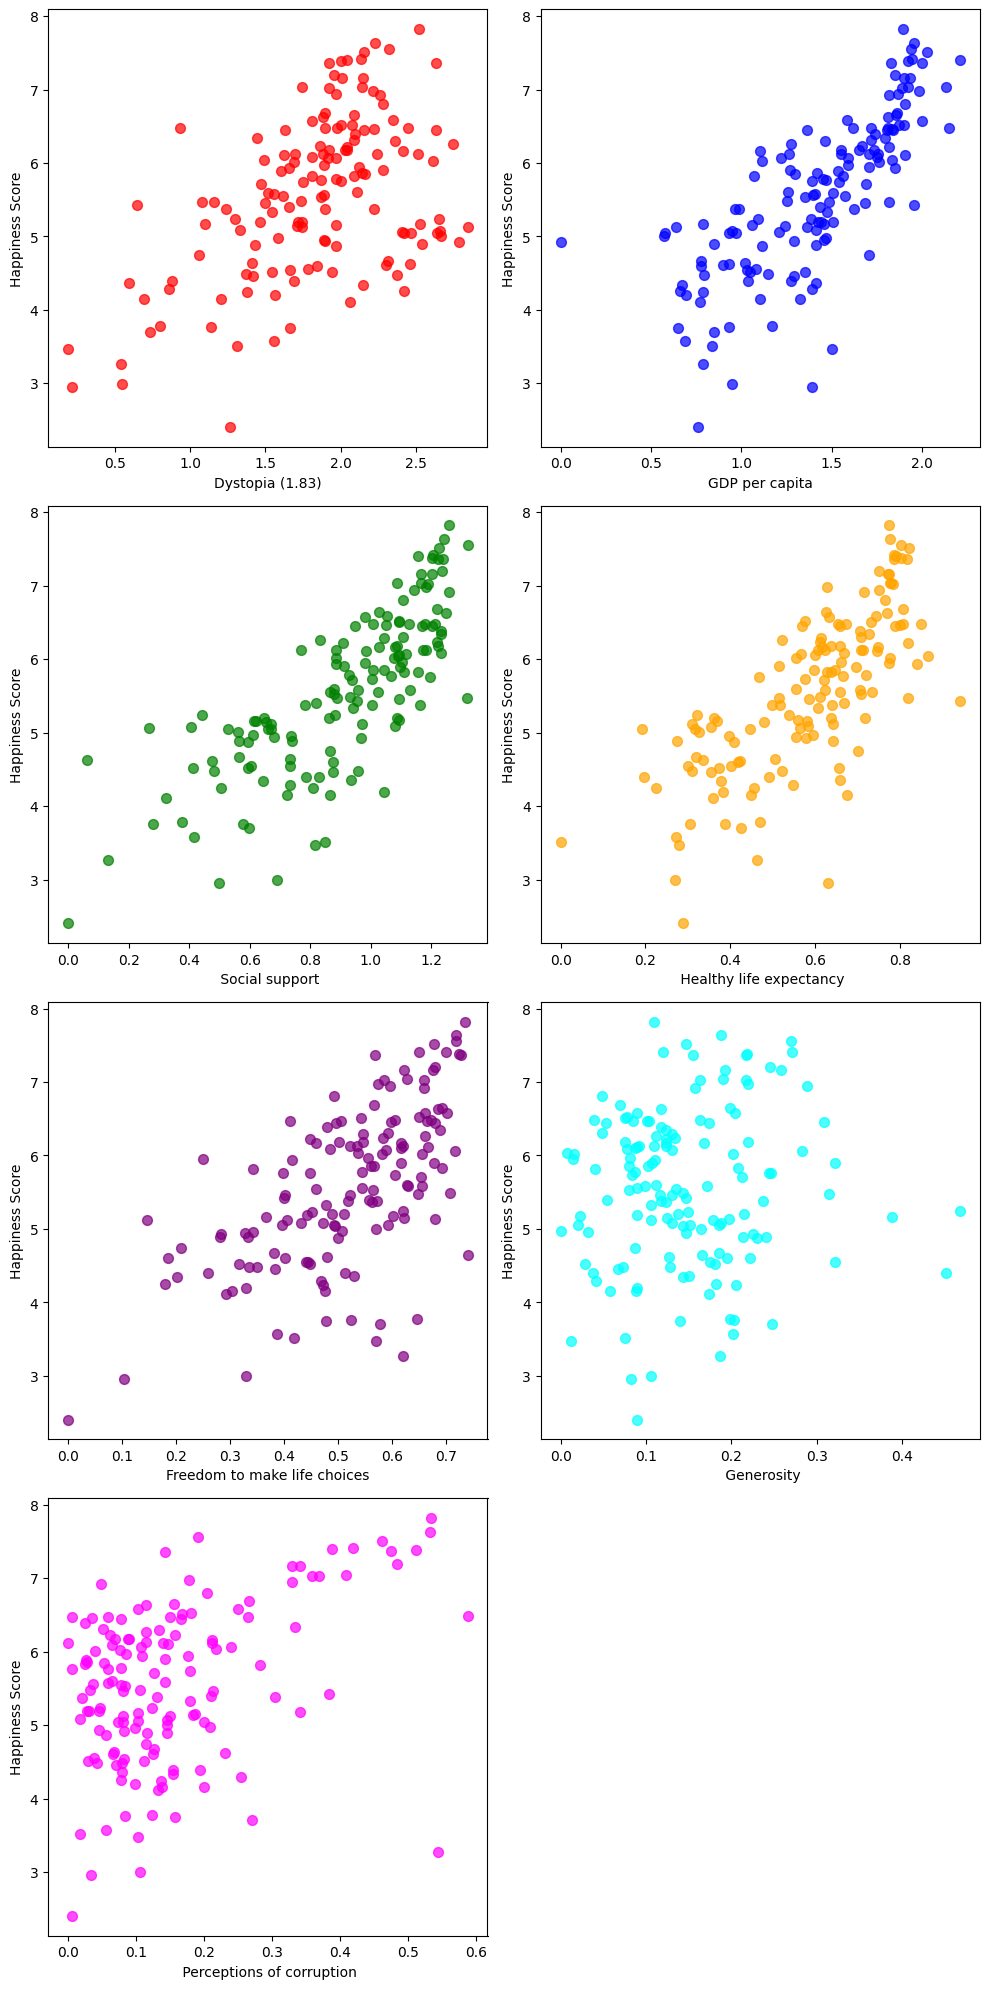

In [10]:
features = data.iloc[:, 1:]
target = data['Happiness score']

num_features = features.shape[1]
num_rows = num_features // 2 + num_features % 2

fig, axs = plt.subplots(num_rows, 2, figsize=(10, 5*num_rows))
axs = axs.flatten()

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

for i, (feature, color) in enumerate(zip(features.columns, colors)):
    row = i // 2
    col = i % 2
    axs[i].scatter(features[feature], target, color=color, marker='o', s=50, alpha=0.7)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Happiness Score')


if num_features % 2 != 0:
    axs[-1].axis('off')

fig.tight_layout()
plt.show()

In [11]:
data['Country'] = df['Country']

# Top 7 countries in each feature

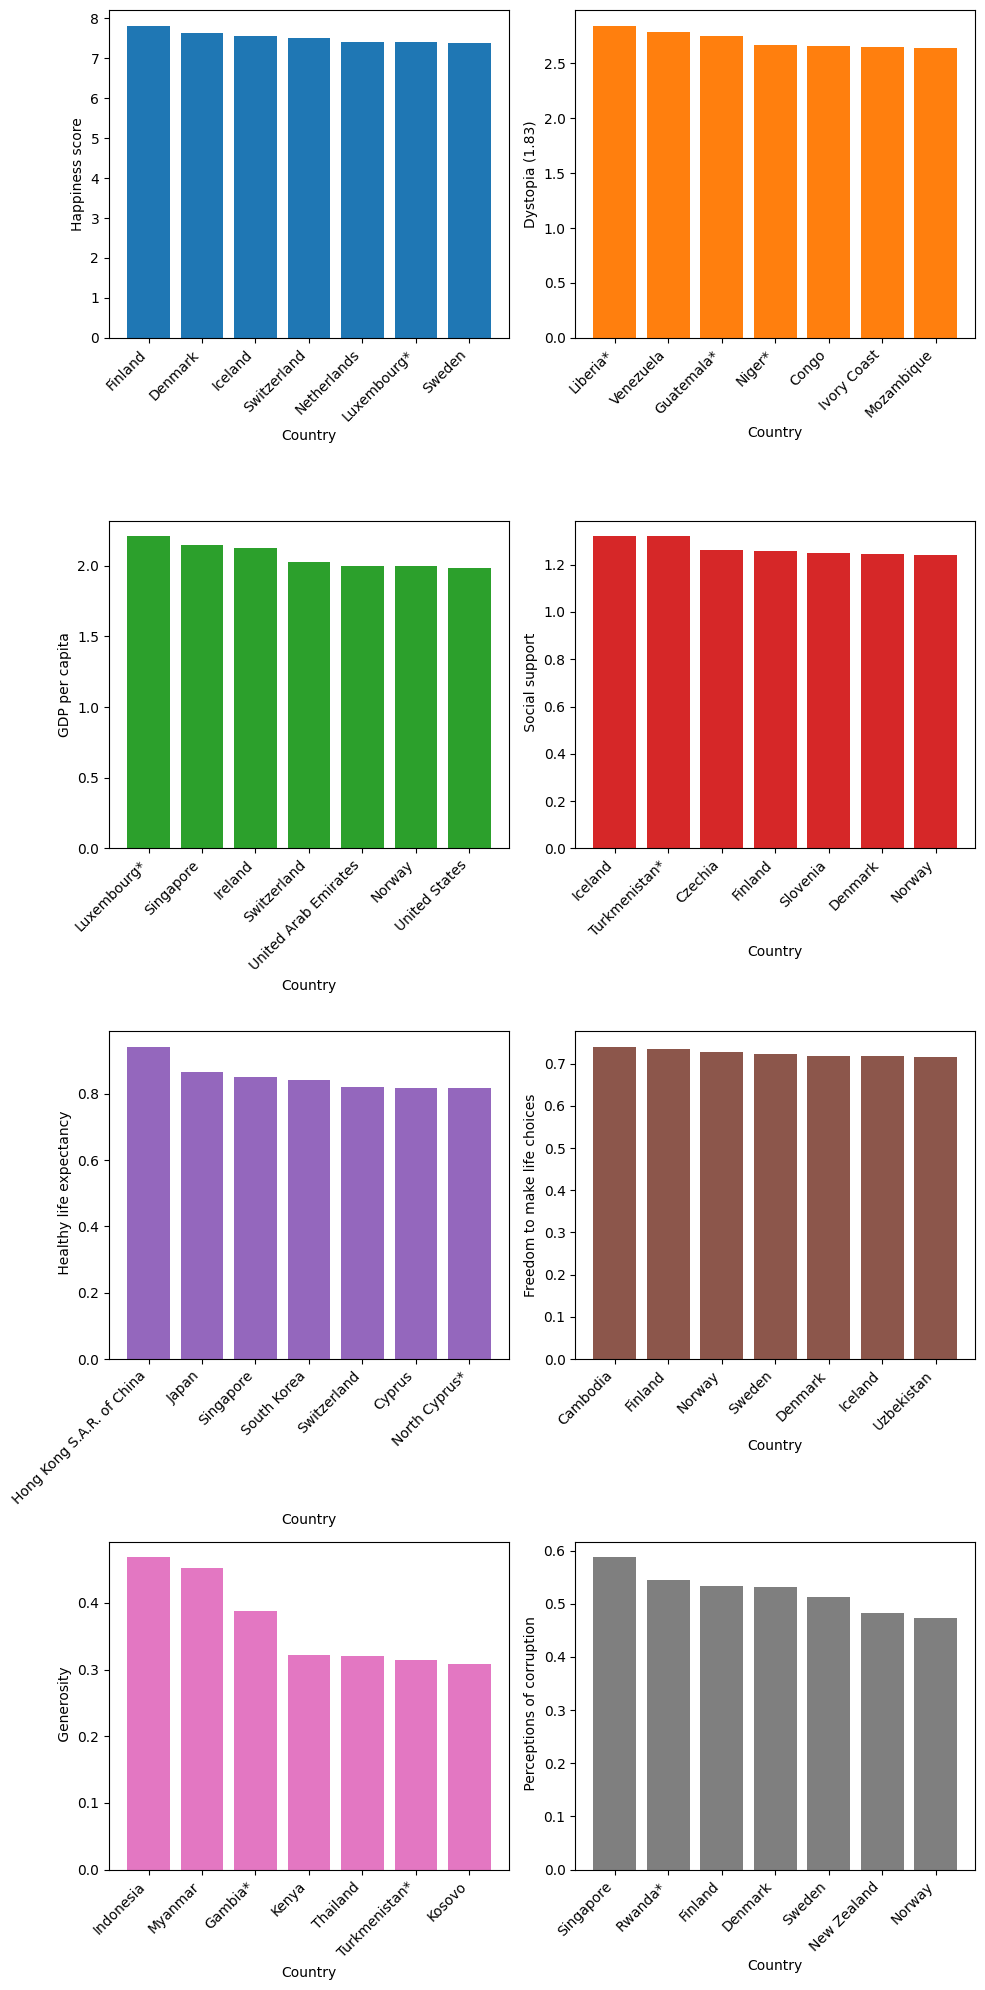

In [12]:
features = data.iloc[:, :-1]
target = data['Happiness score']
num_features = features.shape[1]
num_rows = num_features // 2 + num_features % 2
fig, axs = plt.subplots(num_rows, 2, figsize=(10, 5*num_rows))
axs = axs.flatten()

cmap = plt.get_cmap('tab10')

for i, feature in enumerate(features.columns):
    row = i // 2
    col = i % 2

    top_countries = features.nlargest(7, feature).index

    x = np.arange(len(top_countries))

    color = cmap(i % 10)
    axs[i].bar(x, features.loc[top_countries, feature], color=color)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(data.loc[top_countries, 'Country'], rotation=45, ha='right')

    axs[i].set_xlabel('Country')
    axs[i].set_ylabel(feature)
    axs[i].margins(0.05)

if num_features % 2 != 0:
    axs[-1].axis('off')

fig.tight_layout()
plt.show()

#  Bottom 7 countries in each feature

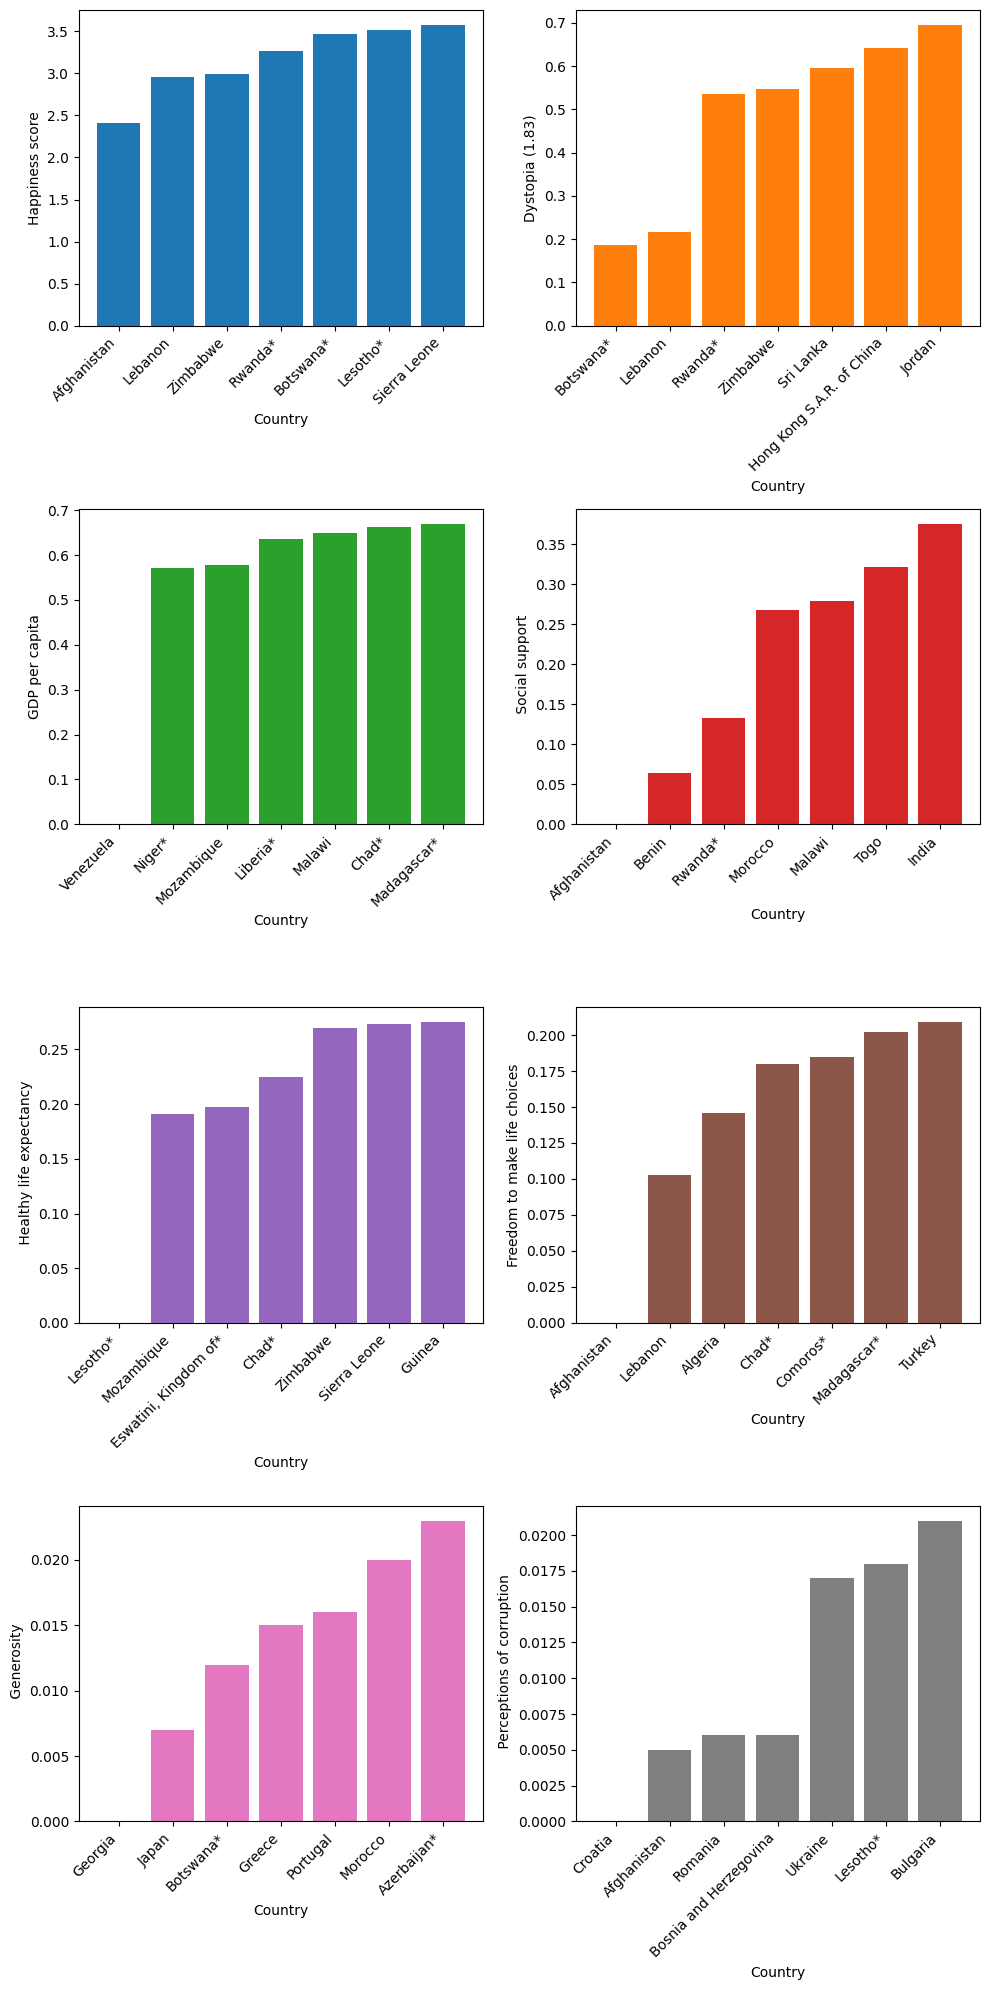

In [13]:
features = data.iloc[:, :-1]
target = data['Happiness score']
num_features = features.shape[1]
num_rows = num_features // 2 + num_features % 2
fig, axs = plt.subplots(num_rows, 2, figsize=(10, 5*num_rows))
axs = axs.flatten()

cmap = plt.get_cmap('tab10')

for i, feature in enumerate(features.columns):
    row = i // 2
    col = i % 2

    top_countries = features.nsmallest(7, feature).index

    x = np.arange(len(top_countries))

    color = cmap(i % 10)
    axs[i].bar(x, features.loc[top_countries, feature], color=color)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(data.loc[top_countries, 'Country'], rotation=45, ha='right')

    axs[i].set_xlabel('Country')
    axs[i].set_ylabel(feature)
    axs[i].margins(0.05)

if num_features % 2 != 0:
    axs[-1].axis('off')

fig.tight_layout()
plt.show()

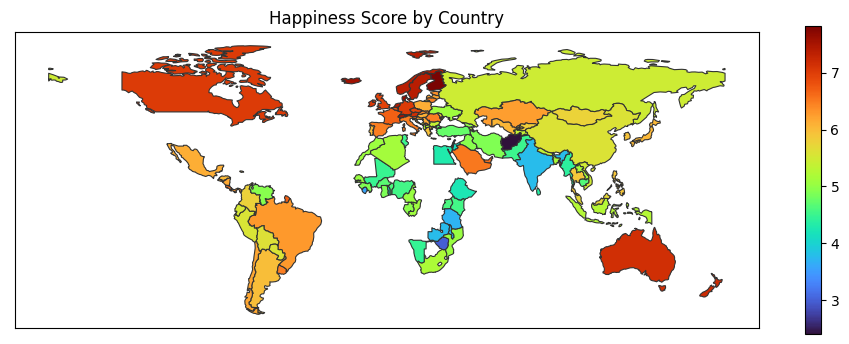

In [14]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
merged_data = world.merge(data, left_on='name', right_on='Country')
fig, ax = plt.subplots(figsize=(12, 4))
merged_data.plot(column='Happiness score', cmap='turbo', linewidth=0.8, ax=ax, edgecolor='0.2', legend=True)
ax.set_title('Happiness Score by Country')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

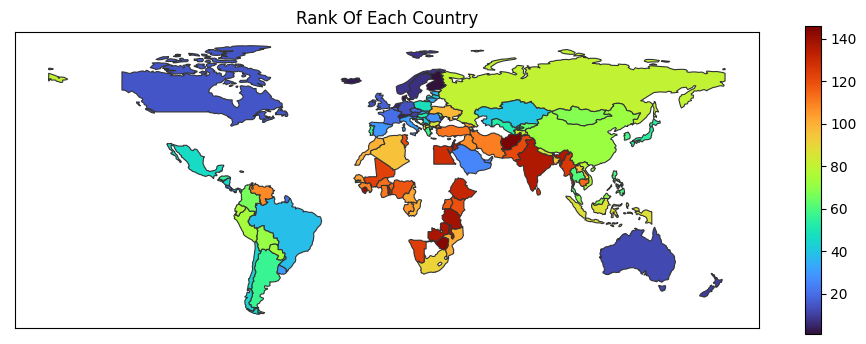

In [15]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
merged_data = world.merge(df, left_on='name', right_on='Country')
fig, ax = plt.subplots(figsize=(12, 4))
merged_data.plot(column='RANK', cmap='turbo', linewidth=0.8, ax=ax, edgecolor='0.2', legend=True)
ax.set_title('Rank Of Each Country')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

# Machine Learning

In [16]:
data = data.sample(frac=1).reset_index(drop=True)

In [17]:
SS=StandardScaler()
scale_data = pd.DataFrame(SS.fit_transform(data.iloc[:,:-1]),columns = data.iloc[:,:-1].columns)

# Regression

In [18]:
X=scale_data.drop(['Happiness score'],axis=1)
y=scale_data['Happiness score']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.1,random_state=21)

In [19]:
selected_models = ['LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor', 'SVR', 'KNeighborsRegressor',
                   'GradientBoostingRegressor', 'AdaBoostRegressor', 'XGBRegressor', 'LGBMRegressor']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the LazyRegressor with the selected models
regressors = [reg for reg in lazypredict.Supervised.REGRESSORS if reg[0] in selected_models]
reg = LazyRegressor(verbose=0, regressors=regressors, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)


'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 11.38it/s]


In [20]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LinearRegression,1.00,1.00,0.00,0.11
GradientBoostingRegressor,0.99,1.00,0.06,0.04
XGBRegressor,0.98,0.99,0.09,0.27
RandomForestRegressor,0.98,0.99,0.10,0.15
DecisionTreeRegressor,0.96,0.98,0.13,0.01
AdaBoostRegressor,0.96,0.98,0.14,0.13
SVR,0.92,0.96,0.18,0.01
LGBMRegressor,0.89,0.95,0.22,0.04
KNeighborsRegressor,0.80,0.90,0.30,0.01


In [21]:
LR=LinearRegression()
LR.fit(X_train,y_train)

LinearRegression()

In [22]:
y_hat=LR.predict(X_test)
print('R2 Score is:',round(r2_score(y_test,y_hat),2))

R2 Score is: 1.0


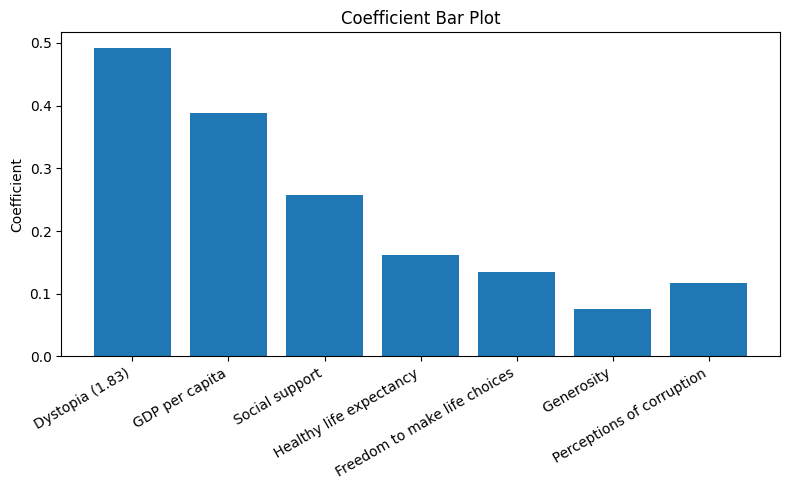

In [23]:
feature_names = X_train.columns
coefficients = LR.coef_
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(feature_names, coefficients)
ax.set_title('Coefficient Bar Plot')
ax.set_ylabel('Coefficient')
plt.xticks(rotation=30, ha='right')

fig.tight_layout()

plt.show()

# Clustering

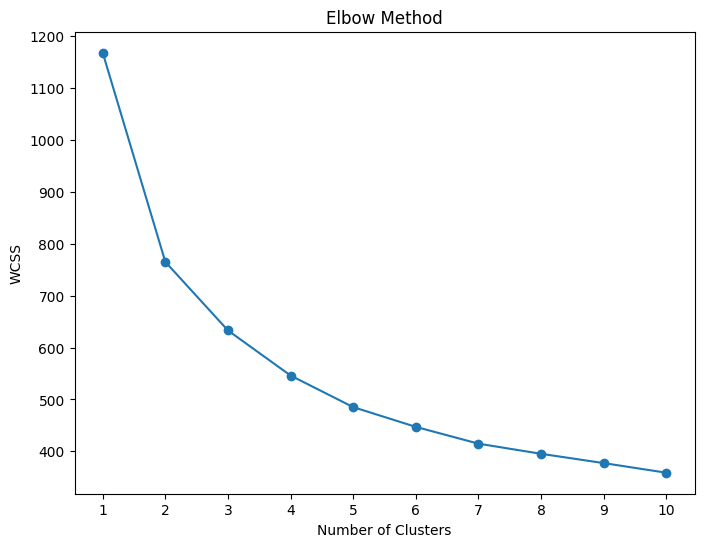

In [24]:
k_values = list(range(1, 11))
wcss_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scale_data)
    wcss_values.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(k_values, wcss_values, marker='o', linestyle='-')
ax.set_title('Elbow Method')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('WCSS')
ax.set_xticks(k_values)
plt.show()

In [25]:
kmeans=KMeans(n_clusters=5)
kmeans.fit(scale_data)

KMeans(n_clusters=5)

In [26]:
data['label']=kmeans.labels_

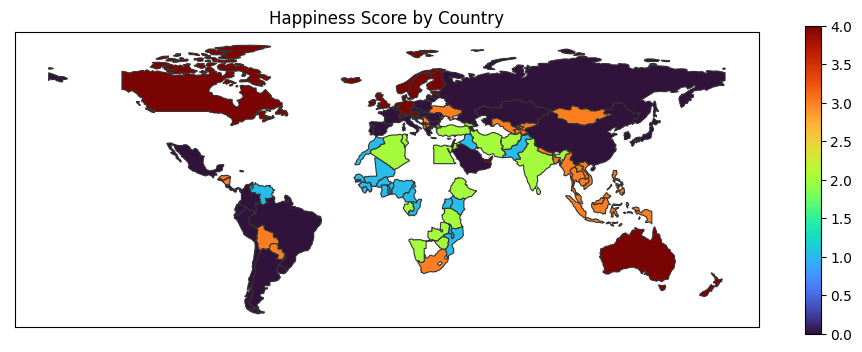

In [27]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
merged_data = world.merge(data, left_on='name', right_on='Country')
fig, ax = plt.subplots(figsize=(12, 4))
merged_data.plot(column='label', cmap='turbo', linewidth=0.8, ax=ax, edgecolor='0.2', legend=True)
ax.set_title('Happiness Score by Country')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

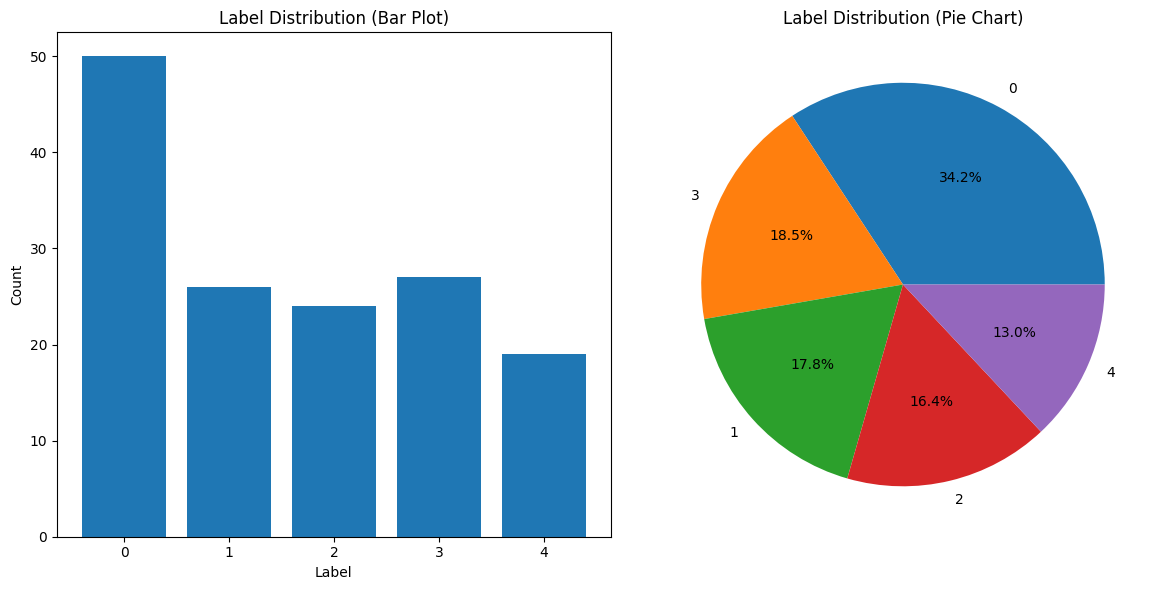

In [28]:
label_counts = data['label'].value_counts()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].bar(label_counts.index, label_counts.values)
axs[0].set_title('Label Distribution (Bar Plot)')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Count')
axs[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
axs[1].set_title('Label Distribution (Pie Chart)')

fig.tight_layout()
plt.show()